### Credmark Modeling Framework Notebook - Curve Pool Balance Ratio

- version 1.0: 2022.7.1
- version 1.1: 2022.6.14


In [15]:
from credmark.cmf.ipython import create_cmf

from credmark.dto import *
from credmark.cmf.types import *

from credmark.cmf.types.ledger import (
    BlockTable, ContractTable,
    LogTable, ReceiptTable, TokenTable, TokenTransferTable,
    TraceTable, TransactionTable, LedgerTable,
    LedgerAggregate, LedgerModelOutput
)

## Initialize

<div class="alert alert-block alert-info">
    <b>Note:</b> Change to a web3 provider you have in `params` below.
</div>


In [16]:
cmf_param = {
    'chain_id': 1,
    'block_number': None,
    # 'chain_to_provider_url': {'1': 'http://localhost:8545'},
    'api_url': None,
    'use_local_models': None,
    'register_utility_global': True
}

context, _model_loader = create_cmf(cmf_param)

ledger = context.ledger
run_model = context.run_model
models = context.models
block_number = context.block_number
chain_id = context.chain_id
web3 = context.web3
run_model_historical = context.historical.run_model_historical
run_model_historical_blocks = context.historical.run_model_historical_blocks

## Curve Pools


In [17]:
from curve_pool_balance_ratio import plot_pool_n, plot_pool_n_data
from datetime import datetime, timedelta, timezone

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
init_notebook_mode(connected=True)

### Installation for plotly with JupyterLab

`$ pip install plotly==5.9.0`

or conda:
`$ conda install -c plotly plotly=5.9.0 `

`$ pip install "jupyterlab>=3" "ipywidgets>=7.6"`
`$ conda install "jupyterlab>=3" "ipywidgets>=7.6"`

You'll need jupyter-dash to add widgets such as sliders, dropdowns, and buttons to Plotly charts in JupyterLab.

`$ pip install jupyter-dash`
or conda:
`$ conda install -c conda-forge -c plotly jupyter-dash`

These packages contain everything you need to run JupyterLab...
`$ jupyter lab`


### Balance Ratio


$value_i = price_i * amount_i$

$ratio = \frac {\prod value_i} {({ \frac {\sum value_i} {n} })^n }$


### 1. Get Curve Pool Information


In [18]:
block_number = BlockNumber.from_ymd(2022, 6, 28)
block_number

curve_pools = ['0x961226b64ad373275130234145b96d100dc0b655',
               '0x8301AE4fc9c624d1D396cbDAa1ed877821D7C511',
               '0x43b4FdFD4Ff969587185cDB6f0BD875c5Fc83f8c',
               '0xd658A338613198204DCa1143Ac3F01A722b5d94A',
               '0xDC24316b9AE028F1497c275EB9192a3Ea0f67022',
               '0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7',
               '0xd632f22692FaC7611d2AA1C0D552930D43CAEd3B',
               '0xCEAF7747579696A2F0bb206a14210e3c9e6fB269',
               '0xD51a44d3FaE010294C616388b506AcdA1bfAAE46',
               '0x5a6A4D54456819380173272A5E8E9B9904BdF41B',
               '0x93054188d876f558f4a66B2EF1d97d16eDf0895B',
               '0x2dded6Da1BF5DBdF597C45fcFaa3194e53EcfeAF',
               '0x9D0464996170c6B9e75eED71c68B99dDEDf279e8',
               '0x828b154032950C8ff7CF8085D841723Db2696056',
               '0x4e0915C88bC70750D68C481540F081fEFaF22273',
               '0xA5407eAE9Ba41422680e2e00537571bcC53efBfD',]

curves_info = (models(block_number)
               .compose.map_inputs(modelSlug='curve-fi.pool-info',
                                   modelInputs=[{'address': addr} for addr in curve_pools]))

### 2. Split into three types


In [19]:
two_pools = [
    {
        'name': '/'.join(pif['output']['tokens_symbol']),
        'ratio':pif['output']['ratio'],
        'a/b': (pif['output']['balances'][0] * pif['output']['token_prices'][0]['price'],
                pif['output']['balances'][1] * pif['output']['token_prices'][1]['price'])
    }
    for pif in curves_info['results']
    if len(pif['output']['tokens_symbol']) == 2
]

three_pools = [
    {
        'name': '/'.join(pif['output']['tokens_symbol']),
        'ratio':pif['output']['ratio'],
        'a/b': (pif['output']['balances'][0] * pif['output']['token_prices'][0]['price'],
                pif['output']['balances'][1] * pif['output']['token_prices'][1]['price'],
                pif['output']['balances'][2] * pif['output']['token_prices'][2]['price'])
    }
    for pif in curves_info['results']
    if len(pif['output']['tokens_symbol']) == 3
]

four_pools = [
    {
        'name': '/'.join(pif['output']['tokens_symbol']),
        'ratio':pif['output']['ratio'],
        'a/b': (pif['output']['balances'][0] * pif['output']['token_prices'][0]['price'],
                pif['output']['balances'][1] * pif['output']['token_prices'][1]['price'],
                pif['output']['balances'][2] * pif['output']['token_prices'][2]['price'],
                pif['output']['balances'][3] * pif['output']['token_prices'][3]['price'])
    }
    for pif in curves_info['results']
    if len(pif['output']['tokens_symbol']) == 4
]

### 3. 2-pool


/tmp/ipykernel_169882/606589305.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator



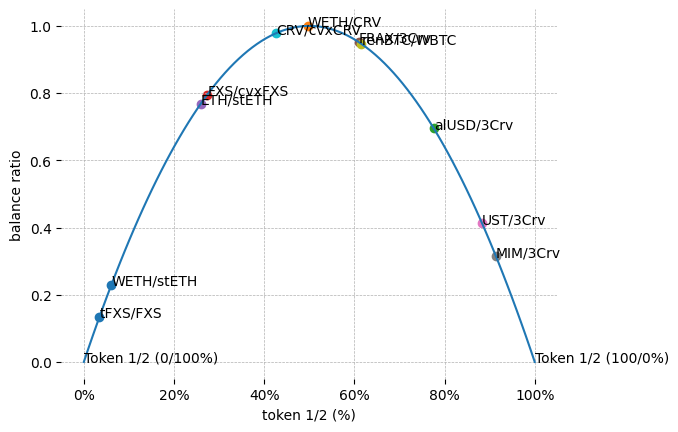

In [20]:
def bal_2pool(xs):
    ys = 1 - xs
    return xs * ys / np.power(1/2, 2)


xs = np.linspace(0, 1, 100)
balance_ratio = bal_2pool(xs)

fig, ax = plt.subplots()
ax.plot(xs, balance_ratio)

for pif in two_pools:
    v1, v2 = pif['a/b']
    r1 = v1 / (v1 + v2)
    ax.scatter(r1, bal_2pool(r1))
    ax.text(r1, bal_2pool(r1), pif['name'])

ax.text(0, 0, 'Token 1/2 (0/100%)')
ax.text(1, 0, 'Token 1/2 (100/0%)')

ax.set_frame_on(False)
ax.set_xlabel('token 1/2 (%)')
ax.set_ylabel('balance ratio')
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
ax.grid(linestyle='--', linewidth=0.5)

plt.show()

### 3-pool


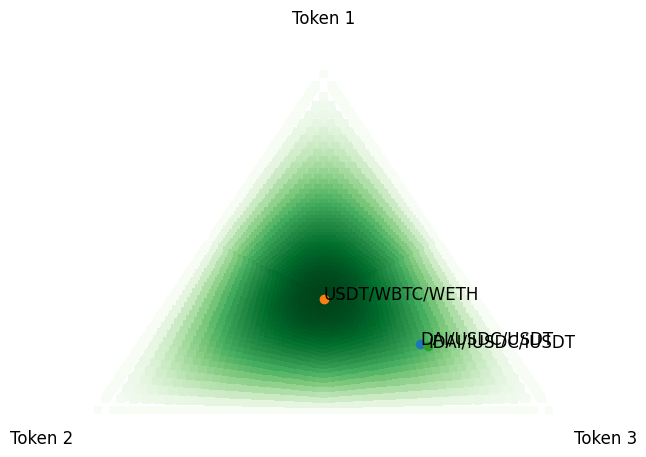

In [21]:
basis = np.array([[0.0, 1.0], [-1.5/np.sqrt(3), -0.5], [1.5/np.sqrt(3), -0.5]])


def bal_ratio_3pool(abc):
    return abc[:, 0] * abc[:, 1] * abc[:, 2] / np.power(1/3, 3)


fig_3pool, ax = plot_pool_n(basis, n_point=30j, pool_n=3, bal_ratio_func=bal_ratio_3pool)

for pif in three_pools:
    three_value = np.array(pif['a/b'])
    three_value = three_value / three_value.sum()
    two_value = np.dot(three_value, basis)
    ax.scatter(two_value[0], two_value[1])
    ax.text(two_value[0], two_value[1], pif['name'], fontsize=12)

plt.show()

### 4-pool


In [22]:
basis = np.array([[1.0, 1.0], [-1.0, 1.0], [-1.0, -1.0], [1.0, -1.0]])


def bal_ratio_4pool(abcd):
    return abcd[:, 0] * abcd[:, 1] * abcd[:, 2] * abcd[:, 3] / np.power(1/4, 4)


data, bal_ratio = plot_pool_n_data(basis, n_point=12j, pool_n=4, bal_ratio_func=bal_ratio_4pool)

df = pd.DataFrame(data)
df.columns = pd.Index(['x', 'y'])
df.loc[:, 'Ratio'] = bal_ratio

df.x = round(df.x / 0.02) / 50
df.y = round(df.y / 0.02) / 50
df = df.groupby(['x', 'y'], as_index=False)['Ratio'].max()

fig = go.Figure(data=[go.Scatter3d(
    x=df.x,
    y=df.y,
    z=df.Ratio,
    mode='markers',
    marker=dict(
        size=12,
        color=df.Ratio,                # set color to an array/list of desired values
        colorscale='Greens',   # choose a colorscale
        opacity=0.8
    )
)])

annoctation_dict = [
    dict(showarrow=False,
         x=xy[0],
         y=xy[1],
         z=0,
         text=f'Token {alpha}',
         xanchor="left",
         xshift=10,
         opacity=0.7,
         font=dict(
             color="black",
             size=12)
         )
    for xy, alpha in zip(basis, range(1, 5))
]

for pif in four_pools:
    four_value = np.array(pif['a/b'])
    four_value = four_value / four_value.sum()
    two_value = np.dot(four_value, basis)
    # fig.scatter(two_value[0], two_value[1])
    annoctation_dict.append(
        dict(
            showarrow=False,
            x=two_value[0],
            y=two_value[1],
            z=pif['ratio'],
            text=pif['name'],
            xanchor="left",
            xshift=10,
            opacity=0.7,
            font=dict(
                color="black",
                size=12))
    )

fig.update_layout(
    uniformtext_minsize=12,
    scene=dict(
        xaxis=dict(type="linear"),
        yaxis=dict(type="linear"),
        zaxis=dict(type="linear"),
        annotations=annoctation_dict))

fig